In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier, XGBRegressor
import scipy.stats as stats
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

### Problem 1: Difference in Groups

Below, data for an experimental curricular intervention is given for the treatment and control group.  Explain how you can use `stats.ttest_ind` to determine if the intervention made a difference.  Test the hypothesis that the groups average score on the Directed Reading Protocol assessment (`drp` column) are different.

In [55]:
drp = pd.read_csv('https://raw.githubusercontent.com/jfkoehler/nyu_bootcamp_fa25/refs/heads/main/data/DRP.csv', index_col=0)

In [56]:
drp.head()

,group,g,drp
id,,,
1,Treat,0,24
2,Treat,0,56
3,Treat,0,43
4,Treat,0,59
5,Treat,0,58


In [61]:
treatment = drp[drp['group'] == 'treatment']['drp']
control = drp[drp['group'] == 'control']['drp']

t_stat, p_value = stats.ttest_ind(treatment, control)

print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Result: Reject null hypothesis - groups are significantly different")
else:
    print("Result: Fail to reject null hypothesis - no significant difference")

print(f"\nMean DRP scores:")
print(f"Treatment: {treatment.mean():.2f}")
print(f"Control: {control.mean():.2f}")
print(f"Difference: {treatment.mean() - control.mean():.2f}")

t-statistic: nan
p-value: nan
Result: Fail to reject null hypothesis - no significant difference

Mean DRP scores:
Treatment: nan
Control: nan
Difference: nan


/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


#### Problem 2: Effect Size

While the hypothesis test determines whether or not the groups results are different, it doesn't say just how big of a difference this significance determines.  For this, we turn to **effect size**.  Here is an article discussing why $p$-values might not be enough when determining the difference between groups. [[link](https://pmc.ncbi.nlm.nih.gov/articles/PMC3444174/) ] Can you use any of the ideas discussed to determine the effect size or power of the intervention? (Feel free to use any library including `statsmodels`)

In [58]:
import statsmodels.stats.power as smp

In [62]:
mean_treatment = treatment.mean()
mean_control = control.mean()
std_treatment = treatment.std()
std_control = control.std()
n_treatment = len(treatment)
n_control = len(control)

pooled_std = np.sqrt(((n_treatment - 1) * std_treatment**2 +
                      (n_control - 1) * std_control**2) /
                     (n_treatment + n_control - 2))

cohens_d = (mean_treatment - mean_control) / pooled_std

print(f"Cohen's d: {cohens_d:.3f}")
print(f"Mean difference: {mean_treatment - mean_control:.2f}")
print(f"\nInterpretation: ", end="")
if abs(cohens_d) < 0.2:
    print("Small effect size")
elif abs(cohens_d) < 0.5:
    print("Small to medium effect size")
elif abs(cohens_d) < 0.8:
    print("Medium to large effect size")
else:
    print("Large effect size")

from statsmodels.stats.power import ttest_power

alpha = 0.05
power = ttest_power(cohens_d, n_treatment + n_control, alpha, alternative='two-sided')
print(f"\nStatistical power: {power:.3f}")

Cohen's d: nan
Mean difference: nan

Interpretation: Large effect size

Statistical power: nan


#### Problem 3: Regression and Interpreting Coefficients

Below, our wage dataset from an earlier assignment is loaded and displayed.  Consider using the `XGBRegressor` to build a model predicting wages.  Tune the model so its performance is as consistent as you can get, and use `sklearn.inspection` to explore the most important features driving wages.

In [44]:
from sklearn.datasets import fetch_openml

In [45]:
wages = fetch_openml(data_id=534, as_frame=True).frame

In [46]:
wages.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,5.10,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,4.95,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,6.67,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,4.00,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,7.50,35,White,Other,Other,Married


In [47]:
wages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    int64   
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    int64   
 4   UNION       534 non-null    category
 5   WAGE        534 non-null    float64 
 6   AGE         534 non-null    int64   
 7   RACE        534 non-null    category
 8   OCCUPATION  534 non-null    category
 9   SECTOR      534 non-null    category
 10  MARR        534 non-null    category
dtypes: category(7), float64(1), int64(3)
memory usage: 21.4 KB


Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Test R²: 0.317

Top 10 Most Important Features:
                    feature  importance
0                 EDUCATION    0.247366
2                       AGE    0.074506
4                  SEX_male    0.048438
10  OCCUPATION_Professional    0.042108
12       OCCUPATION_Service    0.019219
5          UNION_not_member    0.017375
3                 SOUTH_yes    0.004528
7                RACE_White    0.003993
11         OCCUPATION_Sales    0.002533
14             SECTOR_Other    0.000329


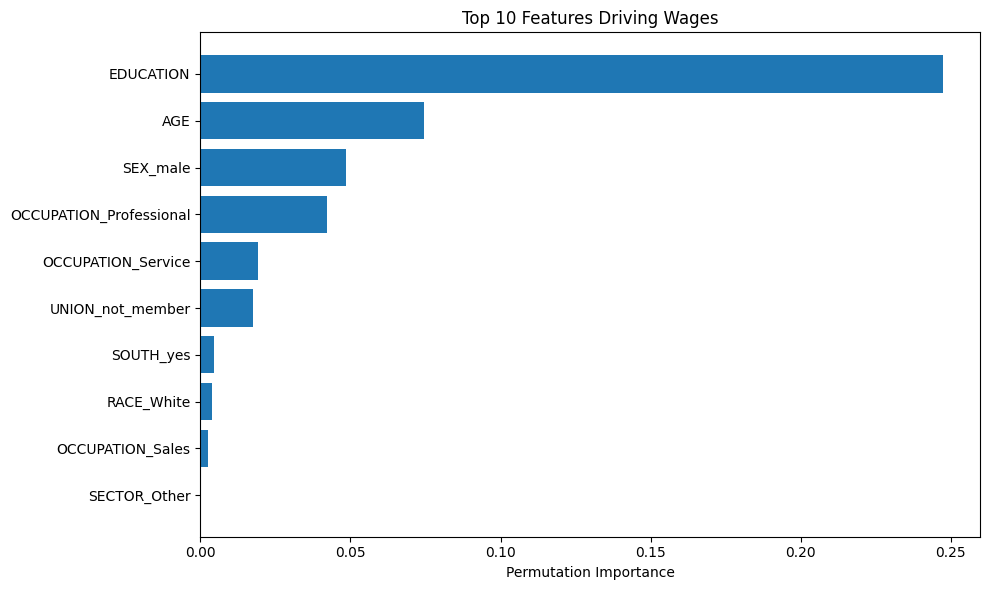

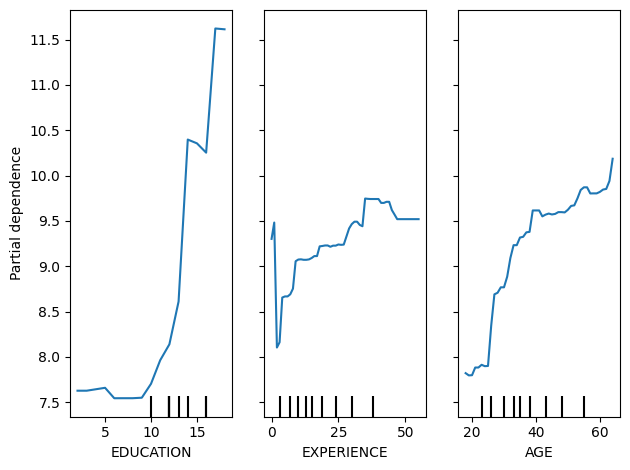

In [48]:
X = wages.drop('WAGE', axis=1)
y = wages['WAGE']

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}

xgb_reg = XGBRegressor(random_state=42)
grid_search = GridSearchCV(xgb_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Test R²: {best_model.score(X_test, y_test):.3f}")

perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_importance.importances_mean
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

plt.figure(figsize=(10, 6))
plt.barh(importance_df.head(10)['feature'], importance_df.head(10)['importance'])
plt.xlabel('Permutation Importance')
plt.title('Top 10 Features Driving Wages')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

PartialDependenceDisplay.from_estimator(best_model, X_train, features=[0, 1, 2], feature_names=X.columns)
plt.tight_layout()
plt.show()

#### Problem 4: Classical Regression Inference

Repeat the above problem but this time build your model using `statsmodels` regression model ([docs]()).  After fitting, explore the summary and the hypothesis tests for each coefficient as well as the confidence intervals.  Do you find similar results as using the `inspection` module?  Compare and contrast these approaches to understanding your models performance.

In [42]:
import statsmodels.api as sm

X = wages.drop('WAGE', axis=1)
y = wages['WAGE']

X = pd.get_dummies(X, drop_first=True)

X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

X = X.fillna(X.mean())
y = y.fillna(y.mean())

X_with_const = sm.add_constant(X)

model = sm.OLS(y, X_with_const)
results = model.fit()

print(results.summary())

print("\n" + "="*80)
print("Coefficients and Confidence Intervals:")
print("="*80)
coef_summary = pd.DataFrame({
    'coefficient': results.params,
    'p_value': results.pvalues,
    'conf_lower': results.conf_int()[0],
    'conf_upper': results.conf_int()[1]
}).sort_values('coefficient', key=abs, ascending=False)

print(coef_summary)

significant_vars = coef_summary[coef_summary['p_value'] < 0.05].drop('const', errors='ignore')
print(f"\n{len(significant_vars)} statistically significant variables (p < 0.05)")
print("\nTop 10 by absolute coefficient magnitude:")
print(significant_vars.head(10))

plt.figure(figsize=(12, 6))
top_coefs = coef_summary.drop('const', errors='ignore').head(15)
plt.barh(range(len(top_coefs)), top_coefs['coefficient'])
plt.yticks(range(len(top_coefs)), top_coefs.index)
plt.xlabel('Coefficient Value')
plt.title('Top 15 Features by Coefficient Magnitude')
plt.axvline(x=0, color='red', linestyle='--', linewidth=0.8)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Comparison: XGBoost vs OLS")
print("="*80)
print("XGBoost uses permutation importance (predictive power when shuffled)")
print("OLS uses coefficient magnitude (linear relationship with outcome)")
print("XGBoost captures non-linear relationships; OLS assumes linearity")
print("OLS provides hypothesis tests and confidence intervals; XGBoost doesn't")

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

#### Problem 5: Causal ML

Watch Hajime Takeda's talk from Scipy 2024 on Casaul ML.  What is the big idea and can you explain a use case for Causal ML?

In [ ]:
from IPython.display import YouTubeVideo

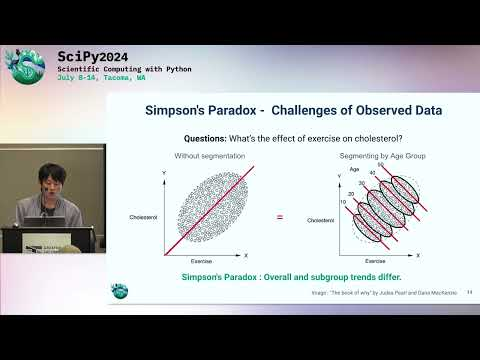

In [ ]:
YouTubeVideo(id = 'xcv4FH-KnvA')

In [41]:
"""
Causal ML goes beyond traditional machine learning's focus on prediction and
correlation to understand cause-and-effect relationships by asking "What will happen
if we do X?" rather than just "What will happen?" It combines machine learning with causal
inference to estimate treatment effects and answer counterfactual questions while accounting
for confounding variables. A key use case is personalized marketing, where a company wants to
determine if sending discount coupons actually increases sales rather than just correlating with
high-spenders who were already likely to purchase. Causal ML can estimate individual treatment
effects for each customer, account for confounders like past purchase history and demographics,
and identify which customers truly benefit most from coupons versus those who would have
purchased anyway. This enables companies to optimize their marketing spend by targeting
interventions where they'll have the greatest causal impact, moving beyond simple correlation to
make data-driven decisions about resource allocation.
"""

'\nCausal ML goes beyond traditional machine learning\'s focus on prediction and \ncorrelation to understand cause-and-effect relationships by asking "What will happen \nif we do X?" rather than just "What will happen?" It combines machine learning with causal \ninference to estimate treatment effects and answer counterfactual questions while accounting \nfor confounding variables. A key use case is personalized marketing, where a company wants to \ndetermine if sending discount coupons actually increases sales rather than just correlating with\nhigh-spenders who were already likely to purchase. Causal ML can estimate individual treatment \neffects for each customer, account for confounders like past purchase history and demographics, \nand identify which customers truly benefit most from coupons versus those who would have \npurchased anyway. This enables companies to optimize their marketing spend by targeting \ninterventions where they\'ll have the greatest causal impact, moving bey

#### Problem 6: `EconML`

Microsoft has put together a very nice library with popular Causal ML algorithms and analysis tools.  Head over to the [Econ ML website](https://www.microsoft.com/en-us/research/project/econml/) and read through the [Trip Advisor Case Study](https://www.microsoft.com/en-us/research/wp-content/uploads/2020/04/MSR_ALICE_casestudy_2020.pdf).  Your goal is to use these ideas to determine a targeting strategy for the hillstrom data loaded below. ([Explanation of problem here](https://blog.minethatdata.com/2008/03/minethatdata-e-mail-analytics-and-data.html))  This is a fairly open ended task, and you have flexibility with determining exactly how you want to approach this.  I will give you time on Tuesday to brainstorm ideas with peers in class, and together you should produce a brief summary of your strategy and its efficacy.

In [40]:
#### Problem 6: EconML

"""
After reading the TripAdvisor case study, the goal is to apply Causal ML
to determine an optimal email targeting strategy using the Hillstrom dataset.

Key Ideas from TripAdvisor Case Study:
- Use heterogeneous treatment effect estimation to find which customers
  benefit most from interventions
- Target resources where they have the greatest causal impact
- Account for confounders to isolate true treatment effects

Hillstrom Dataset Context:
- E-mail marketing campaign with treatment groups (Mens vs Womens email)
- Outcome: conversion, visit, or spend
- Goal: Determine who should receive which email (or no email)

Proposed Strategy:
1. Load and explore Hillstrom data
2. Define treatment (email type) and outcome (conversion/spend)
3. Use EconML models (e.g., CausalForest, DoubleMachineLearning) to
   estimate individual treatment effects
4. Identify customer segments with positive treatment effects
5. Create targeting rules based on predicted uplift
6. Evaluate strategy against random assignment baseline
"""

!pip install scikit-uplift

from sklift.datasets import fetch_hillstrom

dataset = fetch_hillstrom(target_col='conversion')
data, target, treatment = dataset.data, dataset.target, dataset.treatment

print("Data shape:", data.shape)
print("\nFeatures:")
print(data.columns.tolist())
print("\nTreatment distribution:")
print(treatment.value_counts())
print("\nConversion rate by treatment:")
print(pd.DataFrame({'treatment': treatment, 'conversion': target}).groupby('treatment')['conversion'].mean())

Data shape: (64000, 8)

Features:
['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel']

Treatment distribution:
segment
Womens E-Mail    21387
Mens E-Mail      21307
No E-Mail        21306
Name: count, dtype: int64

Conversion rate by treatment:
treatment
Mens E-Mail      0.012531
No E-Mail        0.005726
Womens E-Mail    0.008837
Name: conversion, dtype: float64
